# **Connect to GDRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls '/content/drive/My Drive/skripsiku/Data/split_data'

test  train  val


# **Import Library**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# **Inisiasi Direktori (Split Data)**

In [4]:
train_dir = '/content/drive/My Drive/skripsiku/Data/split_data/train'
val_dir = '/content/drive/My Drive/skripsiku/Data/split_data/val'
test_dir = '/content/drive/My Drive/skripsiku/Data/split_data/test'

# **Data Preparation**

In [11]:
# Augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
# Validasi dan test hanya dilakukan rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Generator untuk validasi
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generator untuk test
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 560 images belonging to 4 classes.
Found 160 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


# **Show Data Augmentasi**

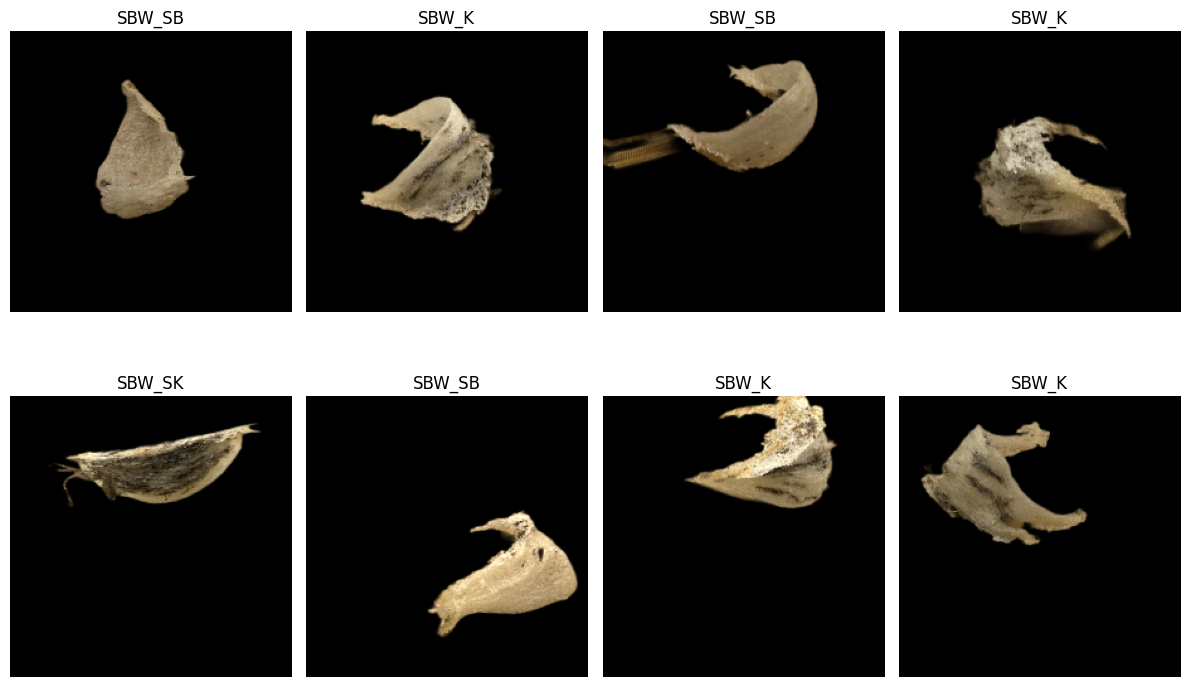

In [13]:
# Ambil satu batch dari train_generator
images, labels = next(train_generator)  # ambil batch pertama

# Ambil mapping kelas dari generator
class_indices = train_generator.class_indices
categories = list(class_indices.keys())  # urutannya sama dengan label output

# Tampilkan 8 gambar pertama
plt.figure(figsize=(12, 8))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    plt.title(categories[label_idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False

model = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # atau train_generator.samples // train_generator.batch_size
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),  # atau val_gen.samples // val_gen.batch_size
    verbose=1  # tampilkan progress bar selama training
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 640s 36s/step - accuracy: 0.2444 - loss: 1.8108 - val_accuracy: 0.3250 - val_loss: 1.4189
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 571s 32s/step - accuracy: 0.2881 - loss: 1.5277 - val_accuracy: 0.4000 - val_loss: 1.4019
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 624s 32s/step - accuracy: 0.3581 - loss: 1.4533 - val_accuracy: 0.4437 - val_loss: 1.2405
Epoch 4/50
 5/18 ━━━━━━━━━━━━━━━━━━━━ 5:31 26s/step - accuracy: 0.3692 - loss: 1.3369